In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

# Qestion 1)

The question asks us to solve (via the relaxation method) the electric field of a charged spherical cylinder inside a box where the walls are at zero potential

('On iteration', 1000, ' the residual is 5.43e-04')
('On iteration', 2000, ' the residual is 1.95e-04')
('On iteration', 3000, ' the residual is 1.08e-04')
('On iteration', 4000, ' the residual is 7.10e-05')
('On iteration', 5000, ' the residual is 5.13e-05')
('On iteration', 6000, ' the residual is 3.95e-05')
('On iteration', 7000, ' the residual is 3.16e-05')
('On iteration', 8000, ' the residual is 2.61e-05')
('On iteration', 9000, ' the residual is 2.20e-05')
('On iteration', 10000, ' the residual is 1.90e-05')
('On iteration', 11000, ' the residual is 1.66e-05')
('On iteration', 12000, ' the residual is 1.46e-05')
('On iteration', 13000, ' the residual is 1.31e-05')
('On iteration', 14000, ' the residual is 1.18e-05')
('On iteration', 15000, ' the residual is 1.07e-05')
('On iteration', 16000, ' the residual is 9.73e-06')
('On iteration', 17000, ' the residual is 8.93e-06')
('On iteration', 18000, ' the residual is 8.24e-06')
('On iteration', 19000, ' the residual is 7.64e-06')
('

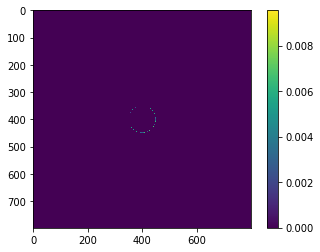

In [2]:
#First, let's start with the geometry. Let's do it in 2D

n_res=800 #resolution of grid

#The potential matrix
V=np.zeros([n_res,n_res]) 

#Boundary condition says all walls are grounded
bc=0.0*V 
mask=np.zeros([n_res,n_res],dtype='bool')
mask[:,0]=True
mask[:,-1]=True
mask[0,:]=True
mask[-1,:]=True


def circle(grid, radius):
    for i in range(n_res):
        for j in range(n_res):
            if (((i-n_res//2)**2 + (j-n_res//2)**2) <= radius**2):
                mask[i,j] = True
                bc[i,j] = 1.0
    return


circleRadius = n_res//16 #1/16 of grid size
circle(V, circleRadius)

#Some more interesting geometry for fun
'''
#mask[ n//2:n//2+n//16, n//2-n//8:n//2+n//8]=True #what cells in grid to apply to (rod in center)
#bc[n//2:n//2+n//16,n//2-n//8:n//2+n//8]=1.0 #positive potential

for i in range(100): 
    sharp = 5.0 #Keep in range (0,4) where 0 is a bar and 4 is a sharp cone. Use >4 for two sources
    mask[n//2-int(i*sharp):n//2+n//16-int(i*sharp),n//2+n//8-i:n//2+n//8+i ]=True #what cells in grid to apply to (cone at end)

    if n//2 < int(i*sharp):
        bc[n//2-int(i*sharp):n//2+n//16-int(i*sharp),n//2+n//8-i:n//2+n//8+i]=-1.0 #negative potential or ground
    else:
        bc[n//2-int(i*sharp):n//2+n//16-int(i*sharp),n//2+n//8-i:n//2+n//8+i]=1.0 #positive potential
'''



residual_relax=1.0
MaxIter = 30*n_res #max number of iterations before stopping
ThresholdResid = 1e-15 #Threshold to hit to deem acceptable

#Relaxation method
V=bc.copy()
i=0
while(i<MaxIter and residual_relax > ThresholdResid):
    V[1:-1,1:-1]=(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])/4.0 #average neighbours
    V[mask]=bc[mask] #Reset BC to original values
    
    if i > 0 and i%1000==0:
        residual_relax = np.sum((V-V_old)**2.) #not really the residual but wtv
        print("On iteration", i, " the residual is %.2e"%residual_relax)
        #print(V)
    V_old = V.copy()
    i+=1
    
if i<MaxIter:
    print("Achieved threshold tolerance after ", i, " iterations")
elif i>=MaxIter:
    print("Reached maximum number of iterations achieving tolerance of ", residual_relax)
    
numIter_relax = i

rho=V[1:-1,1:-1]-(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])/4.0 #The charge

plt.imshow(rho) #charge should only be on the conductor surface!
plt.colorbar()

    



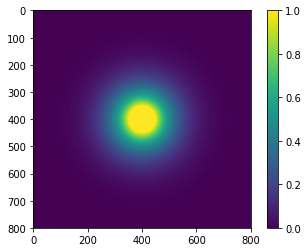

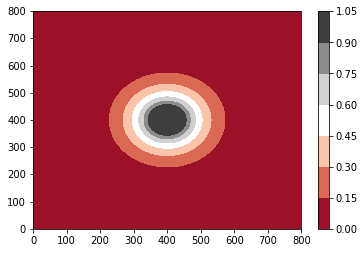

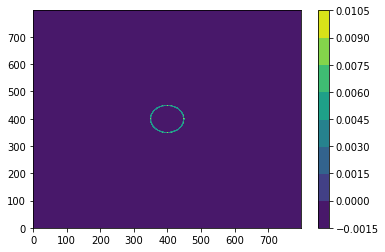

In [3]:
plt.clf()
plt.imshow(V)
plt.colorbar()
plt.show()
plt.clf()
plt.contourf(V, cmap='RdGy')
plt.colorbar()
plt.show()
#plt.imshow(rho, vmin=0.1, vmax=0.12)
plt.contourf(rho)
plt.colorbar()
plt.show()

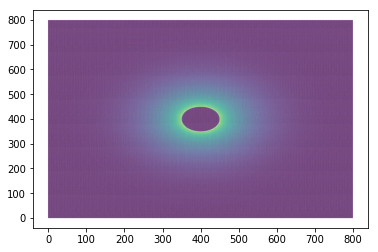

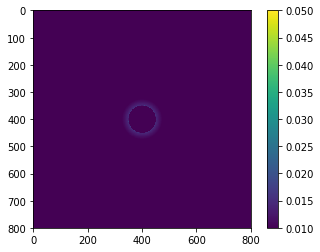

In [5]:
#Plot the electric field
skip=1 #why can't I skip values???
R = np.sqrt(np.gradient(V,1.0)[0]**2. + np.gradient(V,1.0)[1]**2.)
plt.quiver(np.arange(0,n_res)[::skip], np.arange(0,n_res)[::skip],np.gradient(V, 1.0)[0][::skip], np.gradient(V, 1.0)[1][::skip],R[::skip],  color='0.5', 
           units='height', scale=1.0/0.25, pivot='mid', alpha=0.25)
plt.show()

plt.imshow(np.sqrt(np.gradient(V,1.0)[0]**2. + np.gradient(V,1.0)[1]**2.), vmin=0.01, vmax=0.05)
plt.colorbar()


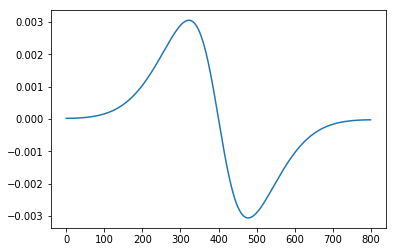

In [7]:
plt.plot(np.arange(n_res)[:],np.gradient(V[:,500][:]))
#plt.plot(np.arange(n)[n//2:], np.log(np.arange(n)[n//2:]))

## Quetion 2) 

Now let's go for the conjugate gradient approach...

In [8]:
def Ax(V,mask):
    #Vuse=np.zeros([V.shape[0]+2,V.shape[1]+2])
    #Vuse[1:-1,1:-1]=V
    Vuse=V.copy()
    Vuse[mask]=0
    ans=(Vuse[1:-1,:-2]+Vuse[1:-1,2:]+Vuse[2:,1:-1]+Vuse[:-2,1:-1])/4.0
    ans=ans-V[1:-1,1:-1]
    return ans

on iteration 0 residual is 7.72e+03
('Surpassed maximum relaxation residual after', 702, ' iterations.')
('Same tolerance achieved in ', 0.02925, 'the number of iterations')
on iteration 1000 residual is 1.67e-09
('Achieved threshold tolerance of ', 1e-15, ' after ', 1800, ' iterations')


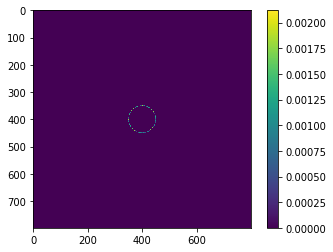

In [9]:
b=-(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
V=0*bc

r=b-Ax(V,mask)
p=r.copy()

residual_conj=1.0  
surpass=False
i=0
while(i<MaxIter and residual_conj > ThresholdResid):
    
    if( (residual_conj<residual_relax) and (surpass==False)):
        print("Surpassed maximum relaxation residual after", i, " iterations.")
        print("Same tolerance achieved in ",float(i)/float(numIter_relax), "the number of iterations")
        surpass = True
    
    Ap=(Ax(np.pad(p, (1,1), mode='constant'),mask))
    residual_conj=np.sum(r*r)
    if i%1000 == 0:
        print('on iteration ' + repr(i) + ' residual is %.2e'%residual_conj)
    alpha=residual_conj/np.sum(Ap*p)

    V=V+np.pad(alpha*p, (1,1), mode='constant')
    rnew=r-alpha*Ap
    beta=np.sum(rnew*rnew)/residual_conj
    p=rnew+beta*p
    r=rnew
    i+=1
rho=V[1:-1,1:-1]-(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])/4.0

if i<MaxIter:
    print("Achieved threshold tolerance of ",ThresholdResid," after ", i, " iterations")
elif i>=MaxIter:
    print("Reached maximum number of iterations")

    
plt.clf();
plt.imshow(rho)
plt.colorbar()

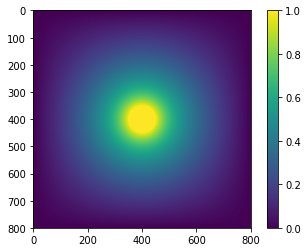

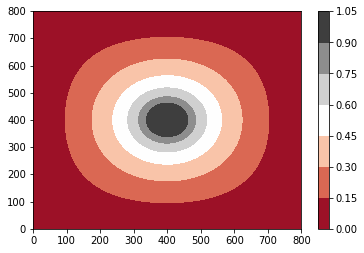

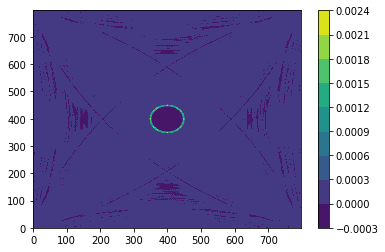

In [10]:
plt.clf()
plt.imshow(V)
plt.colorbar()
plt.show()
plt.clf()
plt.contourf(V, cmap='RdGy')
plt.colorbar()
plt.show()
#plt.imshow(rho, vmin=0.1, vmax=0.12)
plt.contourf(rho)
plt.colorbar()
plt.show()

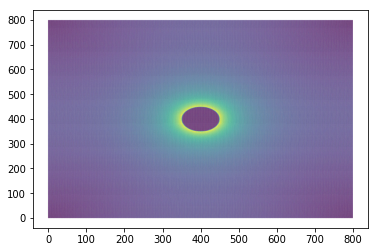

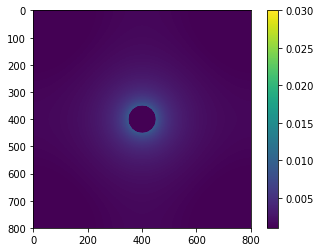

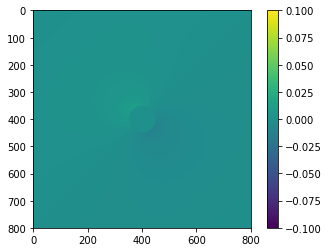

In [13]:
#Plot the electric field
skip=1 #why can't I skip values???
R = np.sqrt(np.gradient(V,1.0)[0]**2. + np.gradient(V,1.0)[1]**2.)
plt.quiver(np.arange(0,n_res)[::skip], np.arange(0,n_res)[::skip],np.gradient(V, 1.0)[0][::skip], np.gradient(V, 1.0)[1][::skip],R[::skip],  color='0.5', 
           units='height', scale=1.0/0.25, pivot='mid', alpha=0.25)
plt.show()

plt.imshow(np.sqrt(np.gradient(V,1.0)[0]**2. + np.gradient(V,1.0)[1]**2.), vmin=0.001, vmax=0.03)
plt.colorbar()

plt.show()
plt.imshow((np.gradient(V,1.0)[0] + np.gradient(V,1.0)[1]), vmin=-0.1, vmax=0.1)
plt.colorbar()

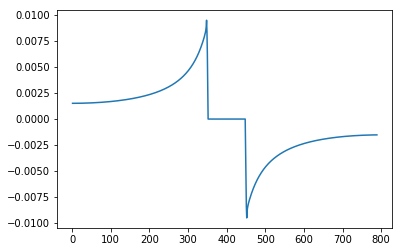

In [15]:
plt.plot(np.arange(n_res)[1:n_res-10],np.gradient(V[:,n_res//2][1:n_res-10]))
